In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

In [ ]:
# ================ Tải và cài đặt thư viện cần thiết ===================
# Chú thích: Cài đặt thư viện datasets nếu chưa có trên Colab
!pip install datasets
!pip install -U datasets huggingface_hub fsspec

In [3]:
# ================ Tải Dataset ===================
# Chú thích: Tải bộ dữ liệu "emotion" từ Hugging Face, chứa các văn bản và nhãn cảm xúc

dataset = load_dataset("emotion")

# Tách dữ liệu thành tập huấn luyện và kiểm tra
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
# ================ Tokenization ===================
# Chú thích: Khởi tạo tokenizer BERT để mã hóa văn bản
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [6]:
def tokenize(texts):
    # Chú thích: Mã hóa văn bản, thêm padding và cắt ngắn nếu cần, trả về tensor PyTorch
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")


In [7]:
train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)


In [8]:
# ================ Custom Dataset ===================
# Chú thích: Tạo lớp EmotionDataset để quản lý dữ liệu mã hóa và nhãn
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

train_dataset = EmotionDataset(train_encodings, train_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)


In [9]:

# ================ Dataloader ===================
# Chú thích: Tạo DataLoader để chia dữ liệu thành các batch, với batch_size=16
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [10]:
# ================ Định nghĩa mô hình ===================
# Chú thích: Xây dựng mô hình phân loại cảm xúc với embedding, Conv1D và fully connected layer
class EmotionClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(EmotionClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)        # (batch_size, seq_len, embedding_dim)
        x = x.permute(0, 2, 1)      # (batch_size, embedding_dim, seq_len)
        x = self.conv1d(x)           # (batch_size, out_channels, seq_len)
        x = self.relu(x)
        x = self.global_avg_pool(x)  # (batch_size, out_channels, 1)
        x = x.squeeze(2)             # (batch_size, out_channels)
        x = self.fc(x)               # (batch_size, num_classes)
        return x


In [11]:
# Khởi tạo mô hình
vocab_size = tokenizer.vocab_size
embedding_dim = 128
num_classes = len(set(train_labels))
model = EmotionClassifier(vocab_size, embedding_dim, num_classes)


In [12]:

# ================ Huấn luyện mô hình ===================
# Chú thích: Thiết lập thiết bị (GPU nếu có, nếu không dùng CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EmotionClassifier(
  (embedding): Embedding(30522, 128)
  (conv1d): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

In [13]:
# Chú thích: Định nghĩa hàm mất mát và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [14]:
# Chú thích: Lưu lại loss của mỗi epoch để vẽ biểu đồ
train_losses = []
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch, labels in train_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch["input_ids"])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/5], Loss: 1.4646
Epoch [2/5], Loss: 0.7740
Epoch [3/5], Loss: 0.3745
Epoch [4/5], Loss: 0.2291
Epoch [5/5], Loss: 0.1531


In [15]:
# ================ Đánh giá mô hình ===================
# Chú thích: Đánh giá mô hình trên tập kiểm tra, tính độ chính xác và các chỉ số khác
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

In [16]:
with torch.no_grad():
    for batch, labels in test_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        labels = labels.to(device)

        outputs = model(batch["input_ids"])
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [17]:
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 88.15%


In [18]:
# Chú thích: Tạo báo cáo phân loại chi tiết (precision, recall, f1-score)
emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=emotions))



Classification Report:
              precision    recall  f1-score   support

     sadness       0.93      0.91      0.92       581
         joy       0.90      0.93      0.91       695
        love       0.74      0.77      0.75       159
       anger       0.86      0.87      0.86       275
        fear       0.87      0.86      0.86       224
    surprise       0.75      0.58      0.65        66

    accuracy                           0.88      2000
   macro avg       0.84      0.82      0.83      2000
weighted avg       0.88      0.88      0.88      2000



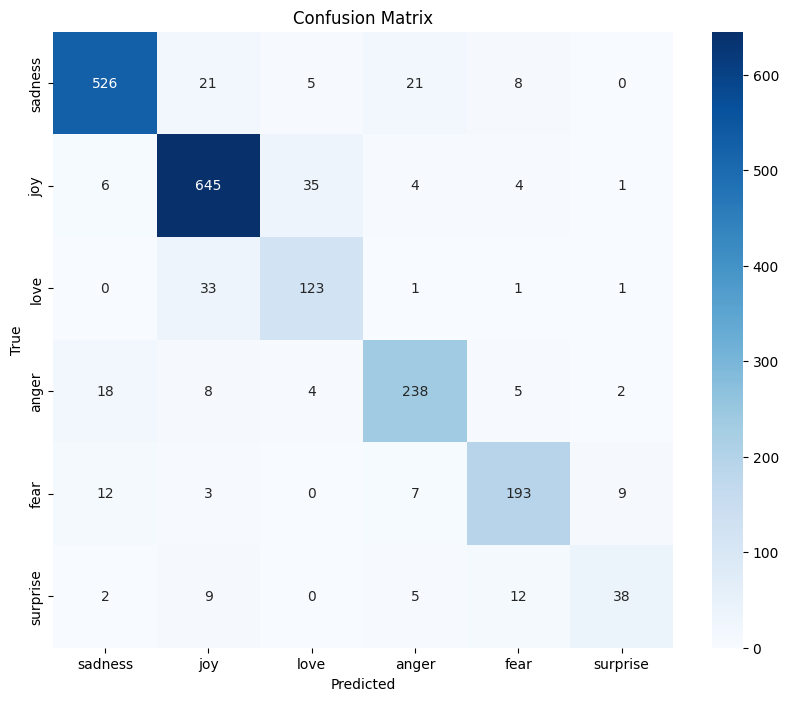

In [19]:
# Chú thích: Vẽ ma trận nhầm lẫn (confusion matrix)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

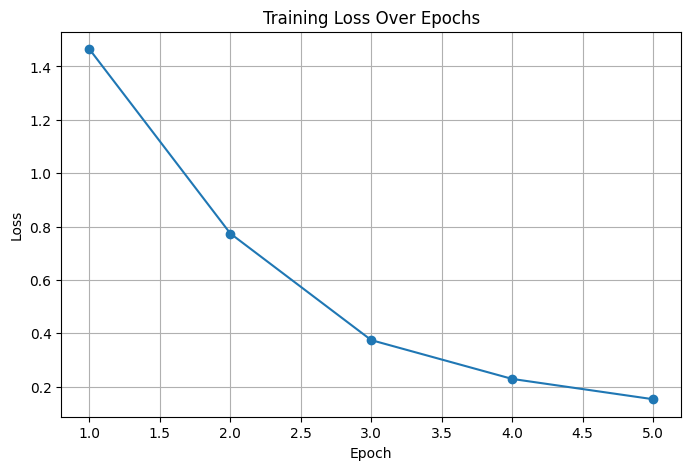

In [20]:
# Chú thích: Vẽ biểu đồ loss qua các epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [38]:
# Tạo và lưu tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer_path = "/content/emotion_tokenizer"
os.makedirs(tokenizer_path, exist_ok=True)
tokenizer.save_pretrained(tokenizer_path)

('/content/emotion_tokenizer/tokenizer_config.json',
 '/content/emotion_tokenizer/special_tokens_map.json',
 '/content/emotion_tokenizer/vocab.txt',
 '/content/emotion_tokenizer/added_tokens.json',
 '/content/emotion_tokenizer/tokenizer.json')

In [39]:
# Kiểm tra các file
required_files = [
    "/content/emotion_tokenizer/config.json",
    "/content/emotion_tokenizer/tokenizer.json",
    "/content/emotion_tokenizer/vocab.txt",
    "/content/emotion_tokenizer/special_tokens_map.json"
]

In [40]:
for file in required_files:
    if os.path.exists(file):
        print(f"File {file} exists.")
    else:
        print(f"Error: File {file} does not exist.")

# Tải các file về máy local
for file in required_files:
    try:
        files.download(file)
    except Exception as e:
        print(f"Failed to download {file}: {str(e)}")

Error: File /content/emotion_tokenizer/config.json does not exist.
File /content/emotion_tokenizer/tokenizer.json exists.
File /content/emotion_tokenizer/vocab.txt exists.
File /content/emotion_tokenizer/special_tokens_map.json exists.
Failed to download /content/emotion_tokenizer/config.json: Cannot find file: /content/emotion_tokenizer/config.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# ================ Dự đoán ===================
# Chú thích: Hàm dự đoán cảm xúc cho một câu mới
def predict(sentence):
    model.eval()
    encoded = tokenize([sentence])
    encoded = {key: val.to(device) for key, val in encoded.items()}

    with torch.no_grad():
        output = model(encoded["input_ids"])
        prediction = torch.argmax(output, dim=1).cpu().item()

    return emotions[prediction]

# Chú thích: Thử nghiệm dự đoán với một câu mẫu
sample_sentence = "I’m so excited about this new adventure!"
print(f"Predicted Emotion: {predict(sample_sentence)}")

Predicted Emotion: joy
